(example_ro_mean_var_portfolio:title)=
# Robust Mean-Variance Portfolio

This case study will replicate the results of a robust mean-variance portfolio model presented in {cite:ps}`Aps2023mosek` in a more concise and straightforward way. The model is written as

$$
\begin{align}
\max~&\min\limits_{\pmb{\mu}\in\mathcal{U}}~\pmb{\mu}^{\top}\pmb{x} - \frac{\delta}{2}\pmb{x}^{\top}\pmb{\Sigma}\pmb{x} \\
\text{s.t.}~&\sum\limits_{i=1}^n\pmb{x} = 1 \\
&\pmb{x}\in\mathbb{R}_+^n,
\end{align}
$$

where the mean returns $\pmb{\mu}$ belongs to the ellipsoidal uncertainty set

$$
\mathcal{U} = \left\{
\pmb{\mu}: \left(\pmb{\mu} - \pmb{\mu}_0\right)^{\top}Q^{-1}\left(\pmb{\mu} - \pmb{\mu}_0\right) \leq \gamma^2
\right\},
$$

with $Q$ being a known positive semidefinite matrix. 

The nominal mean returns $\pmb{\mu}$ and the covariance matrix $\pmb{\Sigma}$ are estimated based on the [stocks.csv](stocks.csv) dataset, which provides the weekly prices of eight stocks from March 21, 2016 to March 18, 2021. 

In [1]:
import pandas as pd

data = pd.read_csv('stocks.csv').set_index('Date')
data

PM         LMT         MCD         MMM        AAPL  \
Date                                                                    
2016-03-14  64.949173  180.019562  102.719170  126.234161   24.238022   
2016-03-21  64.552208  177.648163  102.065163  125.569939   24.180813   
2016-03-28  66.684425  181.812302  105.153030  127.913895   25.169373   
2016-04-04  67.439835  184.411819  105.931198  127.226768   24.865019   
2016-04-11  66.925095  184.012543  105.782211  128.868317   25.137335   
...               ...         ...         ...         ...         ...   
2021-02-15  72.940125  308.861115  198.451248  156.066315  127.806870   
2021-02-22  71.719475  304.100555  192.747543  154.757996  119.333656   
2021-03-01  73.546188  315.877991  195.090607  159.832321  119.491135   
2021-03-08  74.877792  315.655334  199.766327  163.474487  119.107315   
2021-03-15  77.302025  332.598450  209.701019  168.849396  118.615242   

                  MSFT         TXN       CSCO  
Date                                           
2016-03-14   47.876026   46.356270  22.215748  
2016-03-21   48.520458   46.039604  21.925604  
2016-03-28   49.737732   47.046474  22.498055  
2016-04-04   48.708424   47.005863  21.713879  
2016-04-11   49.809334   47.850330  22.078634  
...                ...         ...        ...  
2021-02-15  234.667755  165.299896  42.086960  
2021-02-22  226.823624  159.664795  41.340672  
2021-03-01  226.062317  155.651611  42.612125  
2021-03-08  230.113052  160.869659  44.979977  
2021-03-15  225.203339  161.601852  44.961548  

[262 rows x 8 columns]

Following the data preparation steps introduced in the [Mosek Portfolio Optimization Cookbook](https://docs.mosek.com/portfolio-cookbook/inputdata.html), the estimated mean return and covariance matrix can be returned by the `estimate_return()` function as below.

In [2]:
import numpy as np

def estimate_return(data):
    """
    The estimate_return function estimate the mean and covariance
    matrix of the year rate of return based on the given weekly
    prices of stocks.
    
    Parameters
    ----------
    data : Pandas data frame
        It is a dataset of weekly stock prices. 
    
    Returns
    -------
    mean : Pandas series
        The mean values of the yearly rates of returns.
    cov : Pandas data frame
        The covariance matrix of the year rates of returns. 
        
    Notes:
    ------
    It is assumed that there are 52 weeks in a week. 
    """
    
    factor = 52
    
    wk_log = np.log(data).diff()
    
    mu_log = wk_log.mean() * factor
    Sigma_log = wk_log.cov() * factor
    
    ratio = np.exp(mu_log + (1/2)*np.diag(Sigma_log))
    mean = ratio - 1
    cov = np.outer(ratio, ratio) * (np.exp(Sigma_log) - 1)
    
    return mean, cov

In [3]:
mean, cov = estimate_return(data)

mu0 = mean.values
Sigma = cov.values

We then define the `rmv_portfolio()` function for formulating and solving the robust mean-variance portfolio model. When calling the function, users may specify the estimated mean return `mu0` and estimated covariance matrix `Sigma`, the risk-aversion coefficient `delta`, and the uncertainty parameter `gamma`.

In [4]:
from rsome import ro
from rsome import msk_solver as msk
import rsome as rso

def rmv_portfolio(mu0, Sigma, delta, gamma=0, display=False):
    
    G = np.linalg.cholesky(Sigma)
    Q = G@G.T
    n = len(mu0)
    
    model = ro.Model()
    x = model.dvar(n)
    r = model.dvar()
    
    mu = model.rvar(n)
    uset = rso.quad(mu - mu0, np.linalg.inv(Sigma)) <= gamma**2
    
    
    if gamma == 0:
        model.max(mu0@x - (delta/2)*r)
    else:
        model.maxmin(mu@x - (delta/2)*r, uset)
    
    model.st(rso.quad(x, Sigma) <= r)
    model.st(x.sum() == 1, x >= 0)

    model.solve(msk, display=display)
    
    risk = r()**0.5
    return model.get() + (delta/2)*r(), risk, x.get()

Next, the function is executed repeatedly in the following `for`-loop to find out the worst-case returns, the portfolio risks in terms of the standard deviations, and the optimal solutions, under different risk-aversion preference.

In [5]:
deltas = np.logspace(start=-1, stop=2, num=20)[::-1]

results = pd.DataFrame()
ro_sols = []
nom_sols = []
for i, delta in enumerate(deltas):
    wc_return, risk, xs = rmv_portfolio(mu0, Sigma, delta, gamma=0.02)
    results.loc[i, 'RO Return'] = wc_return
    results.loc[i, 'RO Risk'] = risk
    ro_sols.append(xs) 
    
    wc_return, risk, xs = rmv_portfolio(mu0, Sigma, delta)
    results.loc[i, 'Nominal Return'] = wc_return
    results.loc[i, 'Nominal Risk'] = risk
    nom_sols.append(xs) 
    
ro_sols = np.array(ro_sols)
nom_sols = np.array(nom_sols)

The trade-off between the worst-case mean return and the risk is illustrated by the following figure. 

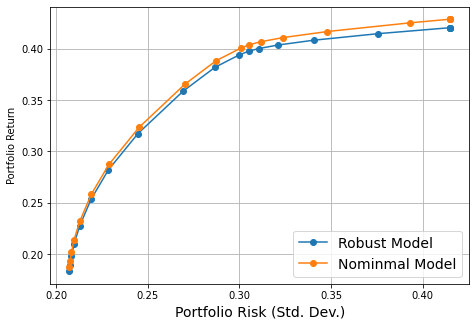

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7.5, 5))
plt.plot(results['RO Risk'], results['RO Return'], marker='o', label='Robust Model')
plt.plot(results['Nominal Risk'], results['Nominal Return'], marker='o', label='Nominmal Model')
plt.legend(fontsize=14)
plt.xlabel('Portfolio Risk (Std. Dev.)', fontsize=14)
plt.ylabel('Portfolio Return')
plt.grid()
plt.show()

Finally, we plot the portfolio allocation $\pmb{x}$ against different portfolio risks as a result of varying the risk-aversion coefficient $\delta$. 

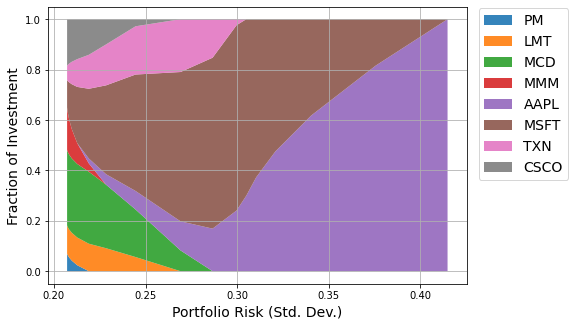

In [7]:
n = data.shape[1]

plt.figure(figsize=(7.5, 5))
bottom = 0
for i in range(n):
    plt.fill_between(results['RO Risk'], bottom, bottom+ro_sols[:, i], 
                     alpha=0.9, 
                     label=data.columns[i])
    bottom += ro_sols[:, i]
    
plt.legend(bbox_to_anchor=(1.26, 1.02), fontsize=14)
plt.xlabel('Portfolio Risk (Std. Dev.)', fontsize=14)
plt.ylabel('Fraction of Investment', fontsize=14)
plt.grid()
plt.show()

Interested readers may refer to the [Mosek Portfolio Optimization Cookbook](https://docs.mosek.com/portfolio-cookbook/factormodels.html#factor-models-example-1) for the similar results.

<br>
<br>

<font size="5">Reference</font>

```{bibliography}
:filter: docname in docnames
```